In [42]:
import numpy as np
import matplotlib.pyplot as plt

IMPORT DATA

In [43]:
file_base =  "inertia"
# file_base = "penalty_implicit"
folder = "DATA"

# file_base2 = "lagr_mult"
# folder = "DATA"

In [44]:
# Carico parametri CSV
csv_file = f"{folder}/{file_base}.csv"
npz_file = f"{folder}/{file_base}.npz"

params_csv = np.genfromtxt(csv_file, delimiter=",", names=True)
resolution = float(params_csv["resolution"])
lx_f = float(params_csv["lx_f"])
ly_f = float(params_csv["ly_f"])
nu_f = float(params_csv["nu_f"])
lx_s = float(params_csv["lx_s"])
ly_s = float(params_csv["ly_s"])
E_s = float(params_csv["E_s"])
nu_s = float(params_csv["nu_s"])
rho_s = float(params_csv["rho_s"])
rho_f = float(params_csv["rho_f"])
dt = float(params_csv["dt"])
Nt  = int(params_csv["Nt"])


# Carico campi numerici NPZ
data = np.load(npz_file, allow_pickle=True)

u_f = data["u_f"]
v_f = data["v_f"]
p_f = data["p_f"]
u_s = data["u_s"]
v_s = data["v_s"]
a_s = data["a_s"]

P = data["P"]
T = data["T"]
d0_x_s = data["d0_x_s"]
d0_y_s = data["d0_y_s"]

print("✅ Data loaded successfully")


dx_f = resolution
dy_f = resolution

nx_f = np.floor(lx_f / dx_f).astype(int)
ny_f = np.floor(ly_f / dy_f).astype(int)

dx_s = resolution 
dy_s = resolution 

nx_s = np.floor(lx_s / dx_s).astype(int)
ny_s = np.floor(ly_s / dy_s).astype(int)
Nb = (nx_s + 1) * (ny_s + 1)

✅ Data loaded successfully


In [45]:
# Carico parametri CSV
# csv_file2 = f"{folder}/{file_base2}.csv"
# npz_file2 = f"{folder}/{file_base2}.npz"

# params_csv2 = np.genfromtxt(csv_file2, delimiter=",", names=True)
# resolution = float(params_csv2["resolution"])
# lx_f = float(params_csv2["lx_f"])
# ly_f = float(params_csv2["ly_f"])
# nu_f = float(params_csv2["nu_f"])
# lx_s = float(params_csv2["lx_s"])
# ly_s = float(params_csv2["ly_s"])
# E_s = float(params_csv2["E_s"])
# nu_s = float(params_csv2["nu_s"])
# dt = float(params_csv2["dt"])
# Nt  = int(params_csv2["Nt"])


# # Carico campi numerici NPZ
# data = np.load(npz_file2, allow_pickle=True)
# u_f = data["u_f"]
# v_f = data["v_f"]
# p_f = data["p_f"]
# u_s2 = data["u_s"]
# v_s2 = data["v_s"]
# P2 = data["P"]
# T2 = data["T"]
# d0_x_s = data["d0_x_s"]
# d0_y_s = data["d0_y_s"]

# print("✅ Data loaded successfully")


# dx_f = resolution
# dy_f = resolution

# nx_f = np.floor(lx_f / dx_f).astype(int)
# ny_f = np.floor(ly_f / dy_f).astype(int)

# dx_s = resolution 
# dy_s = resolution 

# nx_s = np.floor(lx_s / dx_s).astype(int)
# ny_s = np.floor(ly_s / dy_s).astype(int)
# Nb = (nx_s + 1) * (ny_s + 1)

FLUID interpolation

In [46]:
def interpolation(usol, vsol, psol,nx, ny, fine = False):
    """
    Fine interpolation: at each pressure volume, we have 4 velocity subdomains, 
    so we can divide each control volume in 4 equal subvolumes, each ones 
    with a values of u and v depending on the corresponding u and v volume
    """
    u_int = []
    v_int = []
    p_int = []
    if fine:
        u_fine = np.zeros((2*nx, 2*ny))
        v_fine = np.zeros((2*nx, 2*ny))
        for t in range(len(usol)):
            u = usol[t]
            v = vsol[t]
            p = psol[t]
            for i in range(nx):
                for j in range(ny):
                    u_left = u[i,j]       
                    u_right = u[i,j+1]    
                    u_fine[2*i:2*i+2, 2*j]   = u_left
                    u_fine[2*i:2*i+2, 2*j+1] = u_right
                    v_bottom = v[i,j]     
                    v_top = v[i+1,j]   
                    v_fine[2*i, 2*j:2*j+2]   = v_bottom
                    v_fine[2*i+1, 2*j:2*j+2] = v_top

            p_int.append(p[1:-1, 1:-1]) 
            u_int.append(u_fine)
            v_int.append(v_fine)

    else:
        for t in range(len(usol)):
            u = usol[t]
            v = vsol[t]
            p = psol[t]
            
            p_int.append(p[1:-1, 1:-1]) 
            u_int.append((u[1:-1, 2:] + u[1:-1, 1:-1]) * 0.5)
            v_int.append((v[2: , 1:-1] + v[1:-1 , 1:-1]) * 0.5)
    return u_int, v_int, p_int

u_f, v_f, p_f = interpolation(u_f, v_f, p_f, nx_f, ny_f, False)

PLOTS - VISUALIZATION

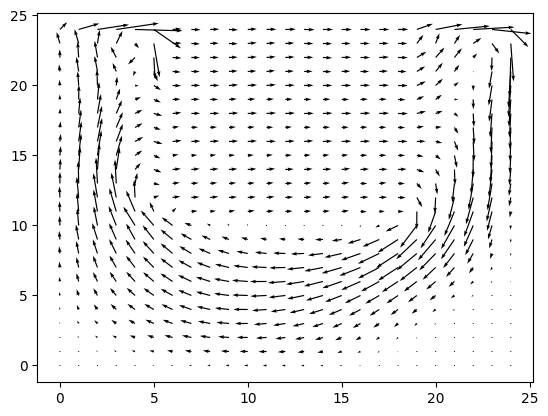

In [55]:
# plt.quiver(u_f[0], v_f[0])
# plt.quiver(u_f[100], v_f[100])
plt.quiver(u_f[-100], v_f[-100])


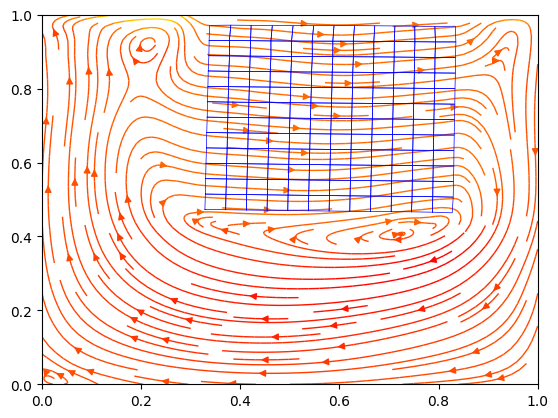

In [48]:
x = np.linspace(0, lx_f, nx_f)
y = np.linspace(0, ly_f, ny_f)
xx, yy = np.meshgrid(x,y)


x_def = P[0, :] + u_s[-1][:Nb] + d0_x_s
y_def = P[1, :] + u_s[-1][Nb:] + d0_y_s
plt.streamplot(xx, yy, u_f[-1], v_f[-1], color=u_f[-1], density=1.5, cmap=plt.cm.autumn, linewidth=1.0)
for e in range(T.shape[1]):
    node_ids = T[:, e]
  
    x_coords = [x_def[i] for i in node_ids] + [x_def[node_ids[0]]] 
    y_coords = [y_def[i] for i in node_ids] + [y_def[node_ids[0]]]
    plt.plot(x_coords, y_coords, color='blue', linewidth=0.5)

plt.xlim(0, lx_f)
plt.ylim(0, ly_f)
plt.show()

Video

In [49]:
from pathlib import Path
output_dir = Path("frames_0")
output_dir.mkdir(parents=True, exist_ok=True) 

x = np.linspace(0, lx_f, nx_f)
y = np.linspace(0, ly_f, ny_f)
xx, yy = np.meshgrid(x,y)

j = 0
for i in range(Nt):
    if i % 5 == 0:
        fig, ax = plt.subplots(figsize=[6, 6], dpi=200)

        uf = u_f[i]
        vf = v_f[i]
        us = u_s[i]
        x_def = P[0, :] + us[:Nb] + d0_x_s
        y_def = P[1, :] + us[Nb:] + d0_y_s

        speed = np.sqrt(uf**2 + vf**2)

        plt.contourf(xx, yy, speed)
        plt.streamplot(xx, yy, uf, vf, color=speed, density=1.0, cmap=plt.cm.autumn, linewidth=1.0)

        for e in range(T.shape[1]):
            node_ids = T[:, e]

            x_coords = [x_def[i] for i in node_ids] + [x_def[node_ids[0]]] 
            y_coords = [y_def[i] for i in node_ids] + [y_def[node_ids[0]]]
            plt.plot(x_coords, y_coords, color='white', linewidth=1.0)

        plt.xlim(0, lx_f)
        plt.ylim(0, ly_f)

        plt.savefig(output_dir / f"frame_{j:04d}.png")
        j += 1
        plt.close()

In [50]:
print(u_s[-1])

[0.07900522 0.07989975 0.08052445 0.08117757 0.08211196 0.08270947
 0.08362511 0.08413441 0.08504639 0.08572965 0.08696056 0.08755642
 0.08828602 0.07918765 0.07978133 0.0806142  0.08116286 0.08221195
 0.08267131 0.08359046 0.08404695 0.08500178 0.08556259 0.08692225
 0.08669937 0.08955509 0.079384   0.07986598 0.08064986 0.08133051
 0.08220346 0.08282214 0.08369117 0.08427831 0.08520235 0.0859201
 0.08691079 0.08766367 0.08884818 0.07930678 0.07991511 0.08064545
 0.08134476 0.0821445  0.08280382 0.08361927 0.08424036 0.08522731
 0.08573487 0.08713796 0.08709012 0.08987922 0.07939655 0.07997198
 0.08070719 0.08141259 0.08218997 0.08281365 0.08362518 0.08433517
 0.08522823 0.08579825 0.08716328 0.08706961 0.09002976 0.07939801
 0.0799692  0.0807158  0.08139963 0.08209359 0.08274366 0.08358459
 0.08426627 0.08524126 0.08577937 0.08718391 0.08701059 0.08983988
 0.07939936 0.08005849 0.08071142 0.08138702 0.08207939 0.08273544
 0.08351627 0.08421652 0.08505287 0.08567395 0.08687007 0.08688

NameError: name 'u_s2' is not defined

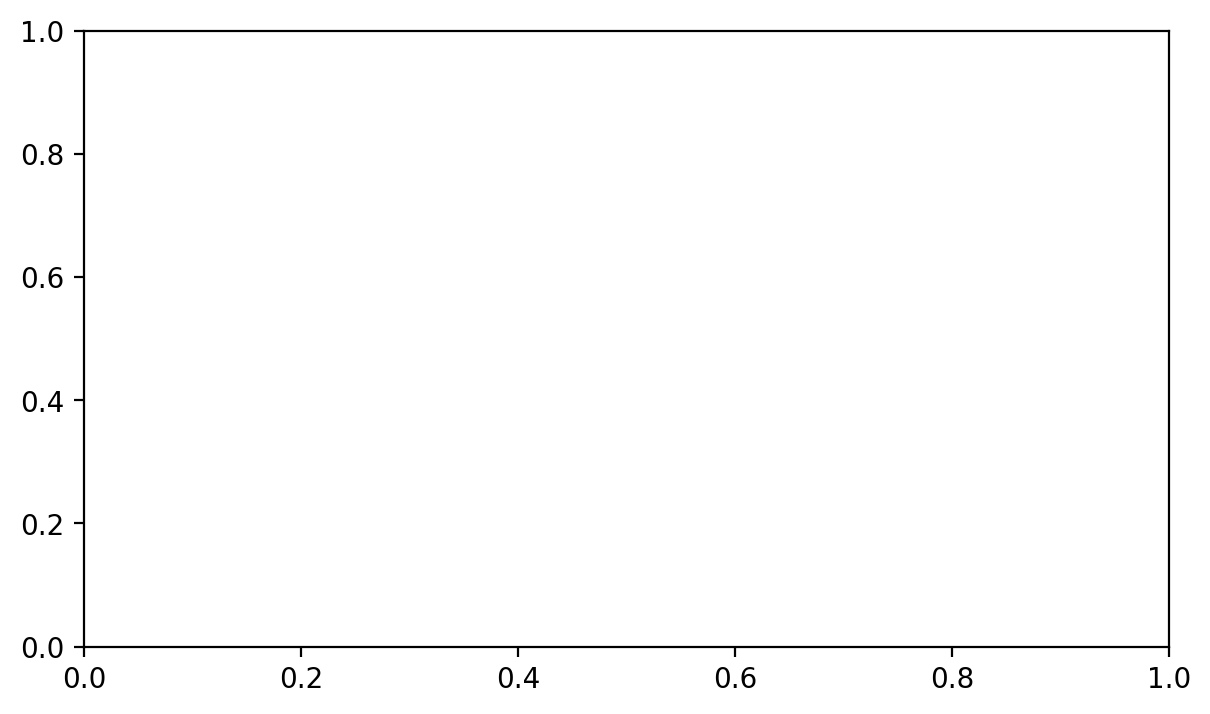

In [51]:
from pathlib import Path
output_dir = Path("frames_comparison")
output_dir.mkdir(parents=True, exist_ok=True) 

x = np.linspace(0, lx_f, nx_f)
y = np.linspace(0, ly_f, ny_f)
xx, yy = np.meshgrid(x,y)

j = 0
for i in range(Nt):
    if i % 5 == 0:
        fig, ax = plt.subplots(figsize=[7, 4], dpi=200)

        us1 = u_s[i]
        us2 = u_s2[i]
        x_def1 = P[0, :] + us1[:Nb] + d0_x_s
        y_def1 = P[1, :] + us1[Nb:] + d0_y_s

        x_def2 = P[0, :] + us2[:Nb] + d0_x_s
        y_def2 = P[1, :] + us2[Nb:] + d0_y_s

    

        for e in range(T.shape[1]):
            node_ids = T[:, e]

            x_coords = [x_def1[i] for i in node_ids] + [x_def1[node_ids[0]]] 
            y_coords = [y_def1[i] for i in node_ids] + [y_def1[node_ids[0]]]
            plt.plot(x_coords, y_coords, color='blue', linewidth=1.0)

            x_coords2 = [x_def2[i] for i in node_ids] + [x_def2[node_ids[0]]] 
            y_coords2 = [y_def2[i] for i in node_ids] + [y_def2[node_ids[0]]]
            plt.plot(x_coords2, y_coords2, color='red', linewidth=1.0)



        plt.xlim(0, lx_f)
        plt.ylim(0, ly_f)

        plt.savefig(output_dir / f"frame_{j:04d}.png")
        j += 1
        plt.close()